In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Caricamento del dataset
train = pd.read_csv("dataset/DatasetClassification/TrainDataset20%.csv")
test = pd.read_csv("dataset/DatasetClassification/TestDataset20%.csv")

X_train = train[['points','uci_points','length','climb_total','profile','startlist_quality','position','cyclist_age','delta']]
y_train = train['label']

X_test = test[['points','uci_points','length','climb_total','profile','startlist_quality','position','cyclist_age','delta']]
y_test = test['label']

X_train = X_train.drop(columns=['position'])
X_test = X_test.drop(columns=['position'])

# Controllo se esistono righe duplicate tra train e test
duplicates = X_train.merge(X_test, how='inner').shape[0]
print(f"Numero di righe duplicate tra train e test: {duplicates}")

# Controllo se ci sono indici in comune
common_indices = X_train.index.intersection(X_test.index)
print(f"Numero di indici in comune tra train e test: {len(common_indices)}")

from collections import Counter
print(Counter(y_train))



Numero di righe duplicate tra train e test: 0
Numero di indici in comune tra train e test: 7064
Counter({1: 93271, 0: 17061})


In [46]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = dict(
    zip(
        np.array([0, 1]),  # Converti in array numpy
        compute_class_weight(
            class_weight='balanced', 
            classes=np.array([0, 1]),
            y=y_train
        )
    )
)


### Random Forest

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'class_weight': [None, {0: 0.35, 1: 0.65}]
}

'''Contrariamente a GridSearchCV, non vengono provati tutti i valori dei parametri, 
ma piuttosto un numero fisso di impostazioni dei parametri viene campionato dalle distribuzioni specificate. 
Il numero di impostazioni dei parametri provate è dato da n_iter.'''
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    param_distributions, 
    n_iter=20, 
    scoring='f1_weighted', 
    cv=5, #Determines the cross-validation splitting strategy
    random_state=42
)
random_search.fit(X_train, y_train)
print(random_search.best_params_)


# Definisci il modello
rf = RandomForestClassifier(
    n_estimators=30, 
    criterion='gini', 
    max_features=3, 
    max_depth=4, 
    min_samples_split=2, 
    min_samples_leaf=8, 
    bootstrap=True
)

# Addestra il modello sul set di training
rf.fit(X_train, y_train)

# Effettua le predizioni sul set di test
test_pred_rf = rf.predict(X_test)

# Stampa il report di classificazione
print(classification_report(y_test, test_pred_rf, target_names=['<=50', '>50']))
print(confusion_matrix(y_test, test_pred_rf))


{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': None}
              precision    recall  f1-score   support

        <=50       0.95      0.66      0.78       939
         >50       0.95      0.99      0.97      6125

    accuracy                           0.95      7064
   macro avg       0.95      0.83      0.87      7064
weighted avg       0.95      0.95      0.95      7064

[[ 619  320]
 [  35 6090]]


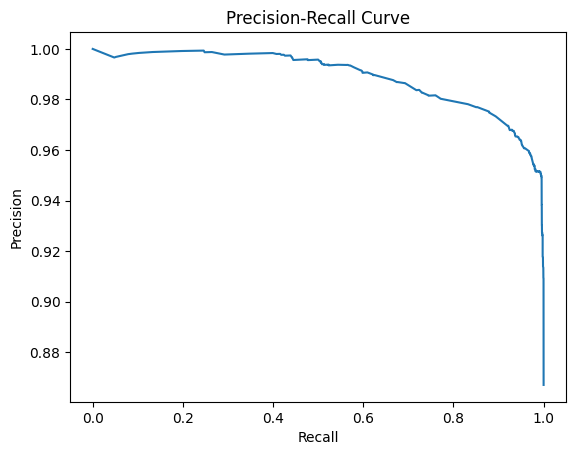

AUC Precision-Recall: 0.9891566138027947


In [48]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

probs = rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

print('AUC Precision-Recall:', auc(recall, precision))


### SVM

In [42]:
from sklearn.preprocessing import StandardScaler

# Scaling dei dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [49]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Definizione del modello SVM
svc = SVC(probability=True, random_state=42)

param_distributions = {
    'C': uniform(0.1, 10),  # Genera valori tra 0.1 e 100
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['linear']
}

random_search = RandomizedSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_distributions=param_distributions,
    n_iter=20,  # Numero di combinazioni casuali da testare
    cv=3,  # Numero di fold
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1  # Usa tutti i core disponibili
)

# Fitting del RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)
print("Migliori iperparametri SVM:", random_search.best_params_)
'''
# Griglia degli iperparametri da testare
param_grid = {
    'C': [0.1, 1, 10, 100],       # penalità
    'kernel': ['linear', 'rbf'],  # kernel: lineare o RBF
    'gamma': [0.01, 0.1, 1, 'scale', 'auto']  # gamma per kernel rbf
}

# Ricerca degli iperparametri con GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='f1', verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Miglior modello SVM trovato
best_svm = grid_search.best_estimator_
print("Migliori iperparametri SVM:", grid_search.best_params_)
'''

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

In [44]:
results = random_search.cv_results_
print(pd.DataFrame(results).sort_values('mean_test_score', ascending=False).head())


AttributeError: 'RandomizedSearchCV' object has no attribute 'cv_results_'

In [ ]:

# Ottenere il miglior modello
best_svm = random_search.best_estimator_
print("Migliori iperparametri SVM:", random_search.best_params_)

# Valutazione sul test set
y_pred = best_svm.predict(X_test_scaled)
y_prob = best_svm.predict_proba(X_test_scaled)[:, 1]  # Probabilità classe positiva

# Metriche di valutazione
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcolo della ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.3f}")

# Predizione sul test set
y_pred = best_svm.predict(X_test_scaled)
y_prob = best_svm.predict_proba(X_test_scaled)[:, 1]  # Probabilità classe positiva

# Metriche di valutazione
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcolo della ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.3f}")


Migliori iperparametri SVM: {'C': np.float64(37.55401188473625), 'gamma': 1, 'kernel': 'linear'}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       939
           1       1.00      1.00      1.00      6125

    accuracy                           1.00      7064
   macro avg       1.00      1.00      1.00      7064
weighted avg       1.00      1.00      1.00      7064

ROC-AUC Score: 1.000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       939
           1       1.00      1.00      1.00      6125

    accuracy                           1.00      7064
   macro avg       1.00      1.00      1.00      7064
weighted avg       1.00      1.00      1.00      7064

ROC-AUC Score: 1.000


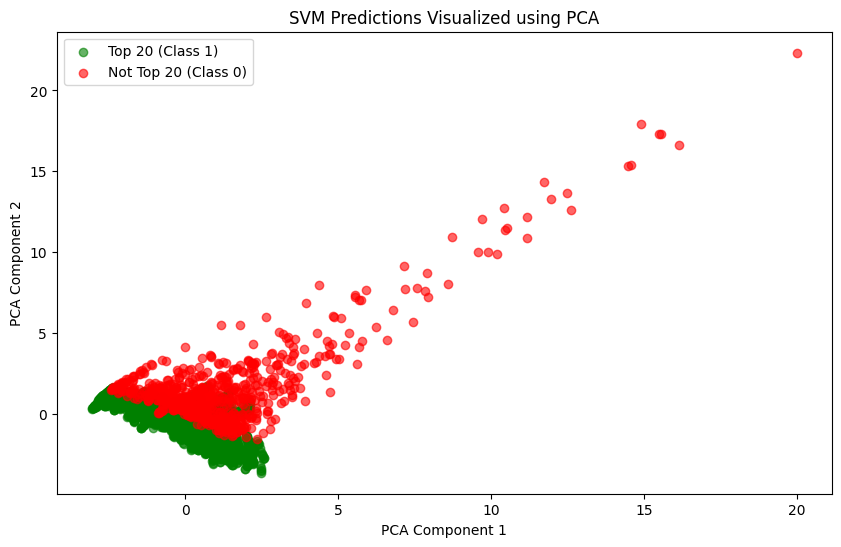

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Riduzione a 2 componenti con PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Predizione con il modello migliore
y_pred_pca = best_svm.predict(X_test_scaled)

# Visualizzazione scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[y_test == 1, 0], X_test_pca[y_test == 1, 1], color='green', label='Top 20 (Class 1)', alpha=0.6)
plt.scatter(X_test_pca[y_test == 0, 0], X_test_pca[y_test == 0, 1], color='red', label='Not Top 20 (Class 0)', alpha=0.6)
plt.title("SVM Predictions Visualized using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()
